## Initial imports

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, pickle
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from doptools.chem.solvents import SolventVectorizer
from chython import smiles, ReactionContainer
from sklearn.pipeline import Pipeline

from doptools import ChythonCircus, ChythonLinear, Fingerprinter, ComplexFragmentor

%config IPCompleter.use_jedi=False

### Data

Data in this tutorial is taken from <https://doi.org/10.1002/anie.202218659> and is related to the prediction of enantioselectivity of organocatalysts in asymmetric hydroalkoxylation. The catalysts are represented by either their full structure (*SMILES* column) or substituents (*Ar* and *R* columns). To represent the reaction in a way that DOPtools can cauclate the descriptors directly, it is given as a mapped SMILES (*reaction*). In addition, the Ar substituent in the catalyst uses CGR notation for indicating the posiiton of the attachment point, so it is also given as a mapped reaction SMILES (*Ar_formatted* column). The modeled property here is *ddG calib (C=0.05)*. which is a free energy difference $\Delta\Delta G$ between enantiomers of the product, calibrated to the same conditions (concentration at 0.05M and temperature are included in the value).

In [2]:
data = pd.read_excel("Selectivity_data_full.xlsx")

data["mol_Ar"] = [smiles(m) for m in data["Ar_formatted"]]
data["mol_R"] = [smiles(m) for m in data["R"]]
data["mol_reac"] = [smiles(m) for m in data["reaction"]]

data

,name,set,SMILES,Ar,R,solvent,concentration,T(K),e.r.,ratio(R),ddG,ddG calib (C=0.05),Ar_formatted,reaction,mol_Ar,mol_R,mol_reac
0,3,a,FC(F)(F)S(=O)(=O)N=P1(NP2(Oc3c(cc4ccccc4c3-c3c...,[C:2][c:1]1ccccc1,FC(F)(F)S(=O)=O,toluene,0.185,313.15,47.0:53.0,0.470000,-0.3128,-0.3504,[cH:3]1[cH:4][cH:5][cH:6][cH:7][c:1]1[CH3:2]>>...,[cH:8]1[cH:9][cH:10][cH:11][cH:12][c:7]1[C:1](...,c1ccccc1C>>C.c1ccccc1,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(=C)CCCO>>c1ccccc1C1(OCCC1)C
1,4,a,Cc1cccc(c1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c(cc4ccc...,[C:2][c:1]1cccc(C)c1,FC(F)(F)S(=O)=O,toluene,0.185,313.15,51.0:49.0,0.510000,0.1042,0.1167,[cH:3]1[c:1]([CH3:2])[cH:8][c:6]([cH:5][cH:4]1...,[cH:8]1[cH:9][cH:10][cH:11][cH:12][c:7]1[C:1](...,c1c(C)cc(cc1)C>>C.c1ccccc1C,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(=C)CCCO>>c1ccccc1C1(OCCC1)C
2,5,a,Cc1ccc(cc1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c(cc4ccc...,[C:2][c:1]1ccc(C)cc1,FC(F)(F)S(=O)=O,toluene,0.185,313.15,44.5:55.5,0.445000,-0.5751,-0.6441,[cH:3]1[cH:4][c:5]([cH:7][cH:8][c:1]1[CH3:2])[...,[cH:8]1[cH:9][cH:10][cH:11][cH:12][c:7]1[C:1](...,c1cc(ccc1C)C>>C.c1ccccc1C,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(=C)CCCO>>c1ccccc1C1(OCCC1)C
3,6,a,FC(F)(F)S(=O)(=O)N=P1(NP2(Oc3c(cc4ccccc4c3-c3c...,[C:2][c:1]1cccc2ccccc12,FC(F)(F)S(=O)=O,toluene,0.050,333.15,77.5:22.5,0.775000,3.4258,3.4258,[CH3:2][c:1]1[cH:3][cH:4][cH:5][c:6]2[c:11]1[c...,[cH:8]1[cH:9][cH:10][cH:11][cH:12][c:7]1[C:1](...,Cc1cccc2c1cccc2>>C.c1cccc2ccccc12,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(=C)CCCO>>c1ccccc1C1(OCCC1)C
4,6,b,FC(F)(F)S(=O)(=O)N=P1(NP2(Oc3c(cc4ccccc4c3-c3c...,[C:2][c:1]1cccc2ccccc12,FC(F)(F)S(=O)=O,cyclohexane,0.050,333.15,79.5:20.5,0.795000,3.7542,3.7542,[CH3:2][c:1]1[cH:3][cH:4][cH:5][c:6]2[c:11]1[c...,[cH:8]1[cH:9][cH:10][cH:11][cH:12][c:7]1[C:1](...,Cc1cccc2c1cccc2>>C.c1cccc2ccccc12,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(=C)CCCO>>c1ccccc1C1(OCCC1)C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,31,c,FC(F)(F)S(=O)(=O)N=P1(NP2(Oc3c(cc4ccccc4c3-c3c...,[C:2][c:1]1ccc2-c3ccccc3C3(CCCCC3)c2c1,FC(F)(F)S(=O)=O,cyclohexane,0.125,333.15,79.9:20.1,0.798531,3.8146,4.6533,[CH2:14]1[CH2:13][C:12]2([CH2:17][CH2:16][CH2:...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,C1CC2(CCC1)c1ccccc1-c1ccc(C)cc12>>C.c1cc2c(cc1...,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
66,56,c,Cc1ccc2-c3ccc(cc3C3(CCCC3)c2c1)-c1cc2ccccc2c-2...,[C:2][c:1]1ccc2-c3ccc(C)cc3C3(CCCC3)c2c1,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,cyclohexane,0.250,333.15,77.8:22.2,0.778370,3.4796,5.5197,[cH:3]1[c:1]([CH3:2])[cH:19][c:18]2[c:5](-[c:6...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,c1c(C)cc2c(-c3c(cc(cc3)C)C23CCCC3)c1>>C.C1CCC2...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
67,57,c,CCCCC1(CCCC)c2ccccc2-c2ccc(cc12)-c1cc2ccccc2c-...,CCCCC1(CCCC)c2ccccc2-c2cc[c:1]([C:2])cc12,FC(F)(F)S(=O)=O,cyclohexane,0.250,333.15,76.5:23.5,0.765416,3.2758,5.1964,[CH2:4]([CH2:5][CH2:6][C:7]1([CH2:8][CH2:9][CH...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,C(CCC1(CCCC)c2c(cccc2)-c2ccc(C)cc12)C>>C.c1c2c...,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
68,58,c,CC1(C)c2ccc(cc2-c2c1ccc1ccccc21)-c1cc2ccccc2c-...,[C:2][c:1]1ccc-2c(c1)C(C)(C)c1ccc3ccccc3c-21,FC(F)(F)S(=O)=O,cyclohexane,0.250,353.15,62.1:37.9,0.620823,1.4477,2.2965,[CH3:9][C:8]1([CH3:10])[c:11]2[c:20](-[c:5]3[c...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,CC1(C)c2c(-c3ccc(C)cc13)c1ccccc1cc2>>C.CC1(C)c...,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C


## Descriptor calculation

To calculate the descriptor here, we use COmplexFragmentor, as we want to represent all components of the reaction, including solvent. For chemical stuctures, we use CircuS fragments (*ChythonCircus*, size varies depending on the structure), and the solvents are represented by their physico-chemical parameters by *SolventVectorizer*.

In [3]:
cf = ComplexFragmentor(associator=[
    ("mol_Ar", ChythonCircus(0,4)),
    ("mol_R", ChythonCircus(0,2)),
    ("mol_reac", ChythonCircus(0,2)),
    ("solvent", SolventVectorizer())
])
cat_descriptors = cf.fit_transform(data)

The following visualization of the resulting descriptor table shows some features of the ComplexFragmentor and calculating features of reactions:

- Each descriptor name starts with the name of the column from which the descriptors were calculated, including solvent.
- The mapped reaction in the data table were internally transformed into CGRs, and their fragments are shown with the notation of dynamic bonds (e.g., [->.]).
- Aromatic bonds may be indicated by ":" for better representation.

In [4]:
cat_descriptors

,mol_Ar::C,mol_Ar::C:C(:C)[->.]C,mol_Ar::C[->.]C,mol_Ar::C:C:C,mol_Ar::C:C:C(:C:C)[->.]C,mol_Ar::C:C:C:C([->.]C):C,mol_Ar::C:C:C:C:C,mol_Ar::C:1:C:C:C:C:C:1[->.]C,mol_Ar::C:1:C:C:C:C:C:1,mol_Ar::C:C(:C)C,...,mol_reac::C:C(:C)C([.>-]OC)(CC)[=>-]C,mol_reac::CC(C)([=>-]C)[.>-]OCC,mol_reac::C(CC([=>-]C)(C)[.>-]O)C,mol_reac::CCCCC,mol_reac::OCCCC,mol_reac::C(O[.>-]C)CC,solvent::SP Katalan,solvent::SdP Katalan,solvent::SA Katalan,solvent::SB Katalan
0,7,2,1,5,2,2,3,12,1,0,...,0,0,0,0,0,0,0.782,0.284,0,0.0128
1,8,2,1,4,2,1,1,1,0,2,...,0,0,0,0,0,0,0.782,0.284,0,0.0128
2,8,2,1,4,2,2,0,2,0,2,...,0,0,0,0,0,0,0.782,0.284,0,0.0128
3,11,2,1,7,0,1,3,0,0,0,...,0,0,0,0,0,0,0.782,0.284,0,0.0128
4,11,2,1,7,0,1,3,0,0,0,...,0,0,0,0,0,0,0.683,0.000,0,0.0730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,19,2,1,7,2,1,2,0,0,4,...,1,1,1,1,1,1,0.683,0.000,0,0.0730
66,19,2,1,6,2,1,0,0,0,6,...,1,1,1,1,1,1,0.683,0.000,0,0.0730
67,22,2,1,7,2,1,2,0,0,4,...,1,1,1,1,1,1,0.683,0.000,0,0.0730
68,20,2,1,9,2,1,2,0,0,4,...,1,1,1,1,1,1,0.683,0.000,0,0.0730


## Model optimization

The model optimization here is launched the same way as in the tutorial 2. In order to save time, if the optimization is launched from here, it is limited in the number of CPUs and optimization steps, so the results may not always achieve the best performance. The model in the original paper has achieved $R^2=0.87$ in 10-fold cross-validation, which we may replicate here. For the sake of time and power saving, other descriptors are not used again, although they can be recalculated in the previous sections.

In [38]:
from doptools import launch_study
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

# we are creating the separate DataFrame for the modeled property to control the name of the column
prop = data[["ddG calib (C=0.05)"]]
prop.columns = ["ddG"]

optimization_study = launch_study({"circus":cat_descriptors},  # the descriptor space should be given as a dictionary {name:descriptor_table, ...}
                                  prop, # the modeled property, has to be a DataFrame, not Series!
                                  "", # output directory, here the results are saved in the variable, so not needed
                                  "SVR", # the methods, Support Vector Regression
                                  500, # number of hyperparameter setups to try. This will take some time!
                                  10, # number of folds in K-fold CV
                                  10, # number of repeats of CV
                                  5, # number of CPUs to use in parallel
                                  120, # timeout, in sec, to kill a process if it is stuck
                                  (0, 0), # early stopiing, here we don't use it
                                  False) # write output into files, here we save in a variable, so not needed

In [39]:
optimization_table = optimization_study[0]
optimization_table.sort_values(by="score", ascending=False)

,trial,score,desc,scaling,method,C,kernel,coef0
178,321,0.842951,circus,scaled,SVR,1.429289e+02,poly,-2.284041
478,20,0.825474,circus,scaled,SVR,4.100738e+03,linear,-8.927733
497,1,0.825457,circus,scaled,SVR,3.070755e+03,linear,-3.405788
496,2,0.825457,circus,scaled,SVR,3.070755e+03,linear,-3.405788
495,3,0.825457,circus,scaled,SVR,3.070755e+03,linear,-3.405788
...,...,...,...,...,...,...,...,...
414,84,NaN,circus,scaled,SVR,6.409601e+07,linear,6.988531
459,39,NaN,circus,scaled,SVR,2.978372e+05,linear,2.776222
460,38,NaN,circus,scaled,SVR,2.978372e+05,linear,2.776222
473,25,NaN,circus,original,SVR,5.129129e+06,linear,1.209285


To visualize the results of CV, we save the predictions in a temporary file (predictions.tmp) and use the plotting function from the plotter module.

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: xlabel='Observed ddG', ylabel='Predicted ddG'>)

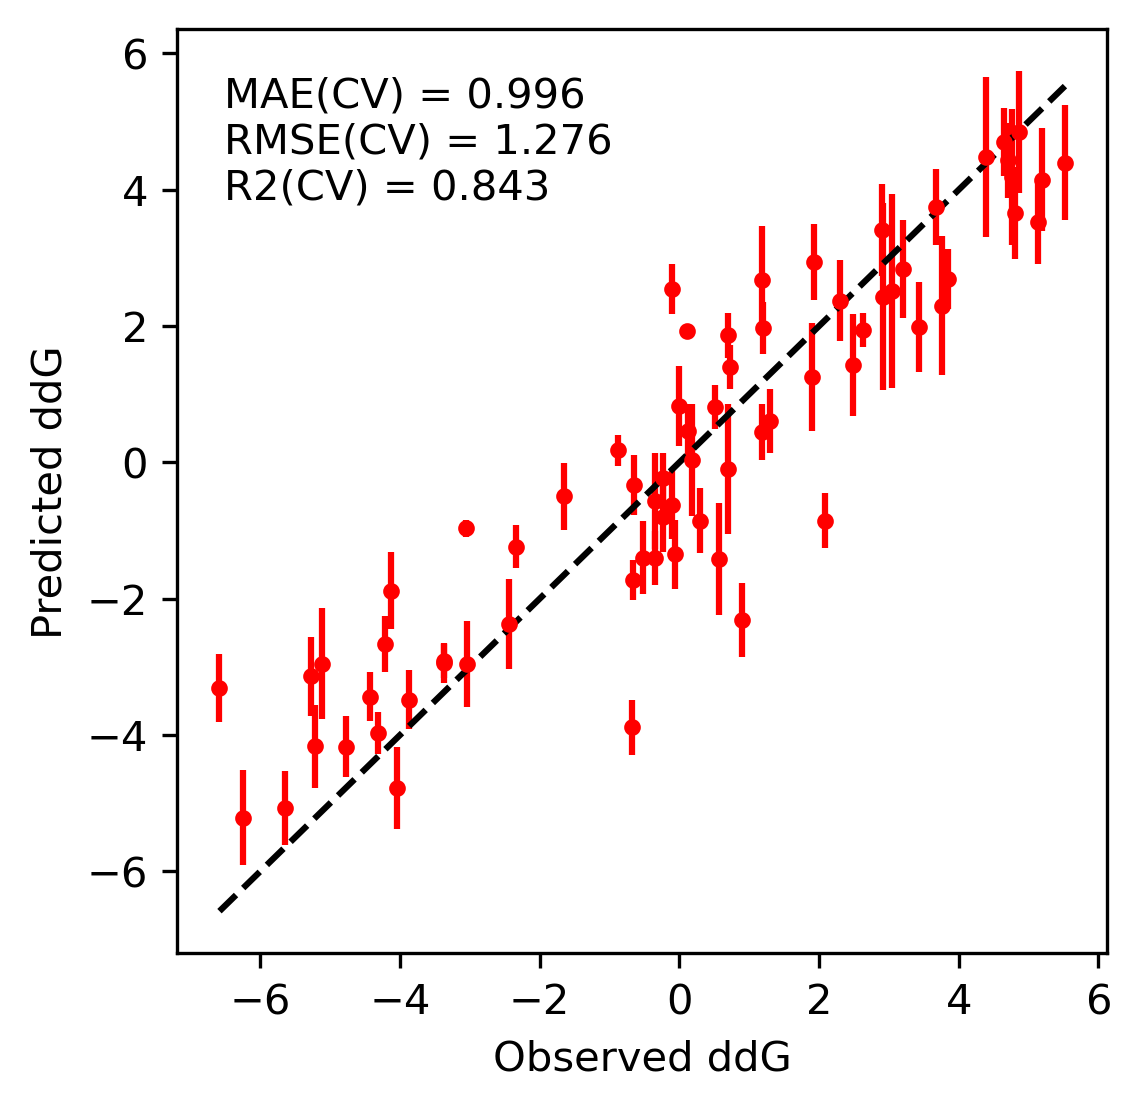

In [44]:
from doptools import make_regression_plot

optimization_study[1][321]["predictions"].to_csv("predictions.tmp", sep=" ", index=None)
make_regression_plot("predictions.tmp", errorbar=True, stats=True)

## External predictions

The test data is from the same paper. We need to have the same columns in the test set DataFrame, so we create the columns with the corresponding structural information here.

In [45]:
test = pd.read_excel("Selectivity_data_test.xlsx")

test["mol_Ar"] = [smiles(m) for m in test["Ar_formatted"]]
test["mol_R"] = [smiles(m) for m in test["R"]]
test["mol_reac"] = [smiles(m) for m in test["reaction"]]

test

,name,set,SMILES,Ar,R,solvent,concentration,T(K),e.r.,ratio(R),ddG,ddG pred,ratio (R) pred,e.r. pred,Ar_formatted,reaction,mol_Ar,mol_R,mol_reac
0,7,THP,CC(C)c1ccc(cc1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c(cc...,CC(C)c1cc[c:1]([C:2])cc1,FC(F)(F)S(=O)=O,cyclohexane,0.25,333.15,31.2:68.8,0.31200,-2.1904,-1.2585,0.3883,38.8:61.2,[cH:7]1[cH:8][c:1]([cH:9][cH:10][c:6]1[CH:4]([...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,c1cc(ccc1C(C)C)C>>C.CC(C)c1ccccc1,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
1,60,THP,CC(C)c1ccc(cc1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c(cc...,CC(C)c1cc[c:1]([C:2])cc1,Fc1c(F)c(F)c2c(F)c(c(F)c(F)c2c1F)S(=O)=O,cyclohexane,0.25,333.15,11.3:88.7,0.11300,-5.7074,-3.5480,0.2174,21.7:78.3,[cH:7]1[cH:8][c:1]([cH:9][cH:10][c:6]1[CH:4]([...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,c1cc(ccc1C(C)C)C>>C.CC(C)c1ccccc1,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
2,61,THP,CC(C)(C)c1ccc(cc1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c...,[C:2][c:1]1ccc(cc1)C(C)(C)C,Fc1c(F)c(F)c2c(F)c(c(F)c(F)c2c1F)S(=O)=O,cyclohexane,0.25,333.15,8.5:91.5,0.08500,-6.5822,-5.2906,0.1290,12.9:87.1,[CH3:9][C:8]([CH3:10])([CH3:11])[c:5]1[cH:4][c...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,CC(C)(C)c1ccc(cc1)C>>C.CC(C)(C)c1ccccc1,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
3,62,THP,Fc1c(F)c(F)c(c(F)c1F)S(=O)(=O)N=P1(NP2(Oc3c(cc...,[C:2][c:1]1cc(cc(c1)C(F)(F)F)C(F)(F)F,Fc1c(F)c(F)c(c(F)c1F)S(=O)=O,cyclohexane,0.25,333.15,53.2:46.8,0.53200,0.3550,-0.9477,0.4153,41.5:58.5,[F:9][C:8]([F:10])([F:11])[c:6]1[cH:7][c:1]([c...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,FC(F)(F)c1cc(cc(C(F)(F)F)c1)C>>C.FC(F)(F)c1ccc...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
4,63,THP,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)S(=O)(=O)N=P1(NP2...,[CH3:2][c:1]1ccc2-c3ccccc3C3(CCCC3)c2c1,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)S(=O)=O,cyclohexane,0.25,333.15,79.2:20.8,0.79200,3.7035,2.5311,0.7138,71.4:28.6,[CH2:14]1[CH2:15][CH2:16][C:12]2([CH2:13]1)[c:...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,C1CCC2(C1)c1cc(C)ccc1-c1ccccc12>>C.c1cccc2c1-c...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
5,64,THP,CC(C)(C)c1ccc(cc1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c...,[C:2][c:1]1ccc(cc1)C(C)(C)C,Fc1c(F)c(F)c(c(F)c1F)S(=O)=O,cyclohexane,0.25,333.15,9.9:90.1,0.09926,-6.1091,-4.7166,0.1541,15.4:84.6,[CH3:9][C:8]([CH3:10])([CH3:11])[c:5]1[cH:4][c...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,CC(C)(C)c1ccc(cc1)C>>C.CC(C)(C)c1ccccc1,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
6,65,THP,CCCCc1ccc(cc1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c(cc4...,CCCCc1cc[c:1]([C:2])cc1,FC(F)(F)C(F)(F)S(=O)=O,cyclohexane,0.25,333.15,41.7:58.3,0.41700,-0.9282,-1.0920,0.4027,40.3:59.7,[cH:8]1[cH:9][c:1]([cH:10][cH:11][c:7]1[CH2:6]...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,c1cc(ccc1CCCC)C>>C.c1ccccc1CCCC,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
7,66,THP,CCc1cc(CC)cc(c1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c(c...,CCc1c[c:1]([C:2])cc(CC)c1,FC(F)(F)C(F)(F)S(=O)=O,cyclohexane,0.25,333.15,64.8:35.2,0.64800,1.6904,0.5850,0.5526,55.3:44.7,[c:5]1([cH:6][c:1]([cH:7][c:8]([CH2:9][CH3:10]...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,c1(cc(cc(CC)c1)C)CC>>C.CCc1cccc(CC)c1,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
8,67,THP,FC(F)(F)C1(CC1)c1ccc(cc1)-c1cc2ccccc2c-2c1OP(N...,[C:2][c:1]1ccc(cc1)C1(CC1)C(F)(F)F,FC(F)(F)S(=O)=O,cyclohexane,0.25,333.15,39.4:60.5,0.39400,-1.1925,-3.0910,0.2468,24.7:75.3,[F:12][C:11]([F:13])([F:14])[C:8]1([CH2:9][CH2...,[cH:9]1[cH:10][cH:11][cH:12][cH:13][c:8]1[C:1]...,FC(F)(F)C1(CC1)c1ccc(cc1)C>>C.FC(F)(F)C1(CC1)c...,"(1, 2, 3, 4, 5, 6, 7)",c1ccccc1C(CCCCO)=C>>c1cc(ccc1)C1(OCCCC1)C
9,61,THP,CC(C)(C)c1ccc(cc1)-c1cc2ccccc2c-2c1OP(NP1(Oc3c...,[C:2][c:1]1ccc(cc1)C(C)(C)C,Fc1c(F)c(F)c2c(F)c(c(F)c(F)c

To recreate the model and apply it to the external data, we need to remake the pipeline and retrain it on the train data. Here, we can use the best model from the previous optimization results. Please note that since the optimization runs for a shorter time and not all possible descriptor spaces or representations are tested, the predictions on the test set may be inaccurate. To compare to the results of the original paper, we provide the parameters of the best model from the original paper.

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

#best_model = optimization_table.sort_values(by="score", ascending=False).iloc[0]

pipeline = Pipeline([
    ("fragmentor", ComplexFragmentor(associator=[
            ("mol_Ar", ChythonCircus(0,4)),
            ("mol_R", ChythonCircus(0,2)),
            ("mol_reac", ChythonCircus(0,2)),
            ("solvent", SolventVectorizer())
        ])),
    ("scaler", MinMaxScaler()),
    #("model", SVR(kernel=best_model["kernel"], C=best_model["C"], coef0=best_model["coef0"]))
    ("model", SVR(kernel="rbf", C=1.476478e+04, coef0=4.3))
])

pipeline.fit(data, data["ddG calib (C=0.05)"])
pipeline.predict(test)

array([-1.60840221, -4.86348695, -6.65712658, -0.94666918,  4.79186185,
       -5.8610426 , -0.40512672,  1.37294248, -0.74124979, -6.65712658])

The visualization by ColorAtom is available for this task, and since there are several chemical structures that are included in the model, all of them will be visualized simpultaneously, and the color will be scaled to the maximum among all contributions. Note that you need to specify the columns in the data table that contain the structural information, otherwise the non-structural information (such as solvents or numerical parameters) will cause an error. 

Also, when the reactions are given as input, the ColorAtom instance needs to be given the parameter "reaction". This takes one of two options - if "reactants" is given, the reaction will be represented by the ensemble of reactants, if "products" - by the ensemble of the products. Due to the limitations of the Chython library, CGR cannot be visualized.

In [48]:
from doptools import ColorAtom

ca = ColorAtom(reaction="reactants", structure_cols=["mol_Ar", "mol_R", "mol_reac"])
ca.set_pipeline(pipeline)
ca.output_html(test.iloc[0])